# Integrating PCA in Pipelines - Lab

## Introduction

In a previous section, you learned about how to use pipelines in scikit-learn to combine several supervised learning algorithms in a manageable pipeline. In this lesson, you will integrate PCA along with classifiers in the pipeline. 

## Objectives

In this lab you will: 

- Integrate PCA in scikit-learn pipelines 

## The Data Science Workflow

You will be following the data science workflow:

1. Initial data inspection, exploratory data analysis, and cleaning
2. Feature engineering and selection
3. Create a baseline model
4. Create a machine learning pipeline and compare results with the baseline model
5. Interpret the model and draw conclusions

##  Initial data inspection, exploratory data analysis, and cleaning

You'll use a dataset created by the Otto group, which was also used in a [Kaggle competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/data). The description of the dataset is as follows:

The Otto Group is one of the world’s biggest e-commerce companies, with subsidiaries in more than 20 countries, including Crate & Barrel (USA), Otto.de (Germany) and 3 Suisses (France). They are selling millions of products worldwide every day, with several thousand products being added to their product line.

A consistent analysis of the performance of their products is crucial. However, due to their global infrastructure, many identical products get classified differently. Therefore, the quality of product analysis depends heavily on the ability to accurately cluster similar products. The better the classification, the more insights the Otto Group can generate about their product range.

In this lab, you'll use a dataset containing:
- A column `id`, which is an anonymous id unique to a product
- 93 columns `feat_1`, `feat_2`, ..., `feat_93`, which are the various features of a product
- a column `target` - the class of a product



The dataset is stored in the `'otto_group.csv'` file. Import this file into a DataFrame called `data`, and then: 

- Check for missing values 
- Check the distribution of columns 
- ... and any other things that come to your mind to explore the data 

In [9]:
# Your code here

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Loading data
data = pd.read_csv('otto_group.csv')

In [11]:
# Your code here

# Inspecting dataset
print("Shape of dataset:", data.shape)
data.head()

Shape of dataset: (61878, 95)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [12]:
# Your code here

# Checking for missing values
missing = data.isnull().sum().sum()
print("Total missing values:", missing)

Total missing values: 0


In [13]:
# Your code here

# Checking target variable
print("Target distribution:\n", data['target'].value_counts())

Target distribution:
 target
Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: count, dtype: int64


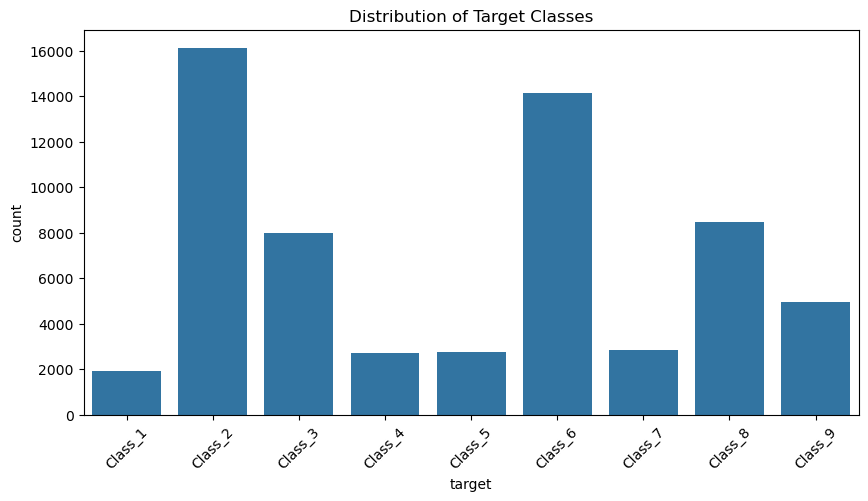

In [14]:
# Your code here

# Plotting distribution of the target
plt.figure(figsize=(10, 5))
sns.countplot(x='target', data=data)
plt.title("Distribution of Target Classes")
plt.xticks(rotation=45)
plt.show()

If you look at all the histograms, you can tell that a lot of the data are zero-inflated, so most of the variables contain mostly zeros and then some higher values here and there. No normality, but for most machine learning techniques this is not an issue. 

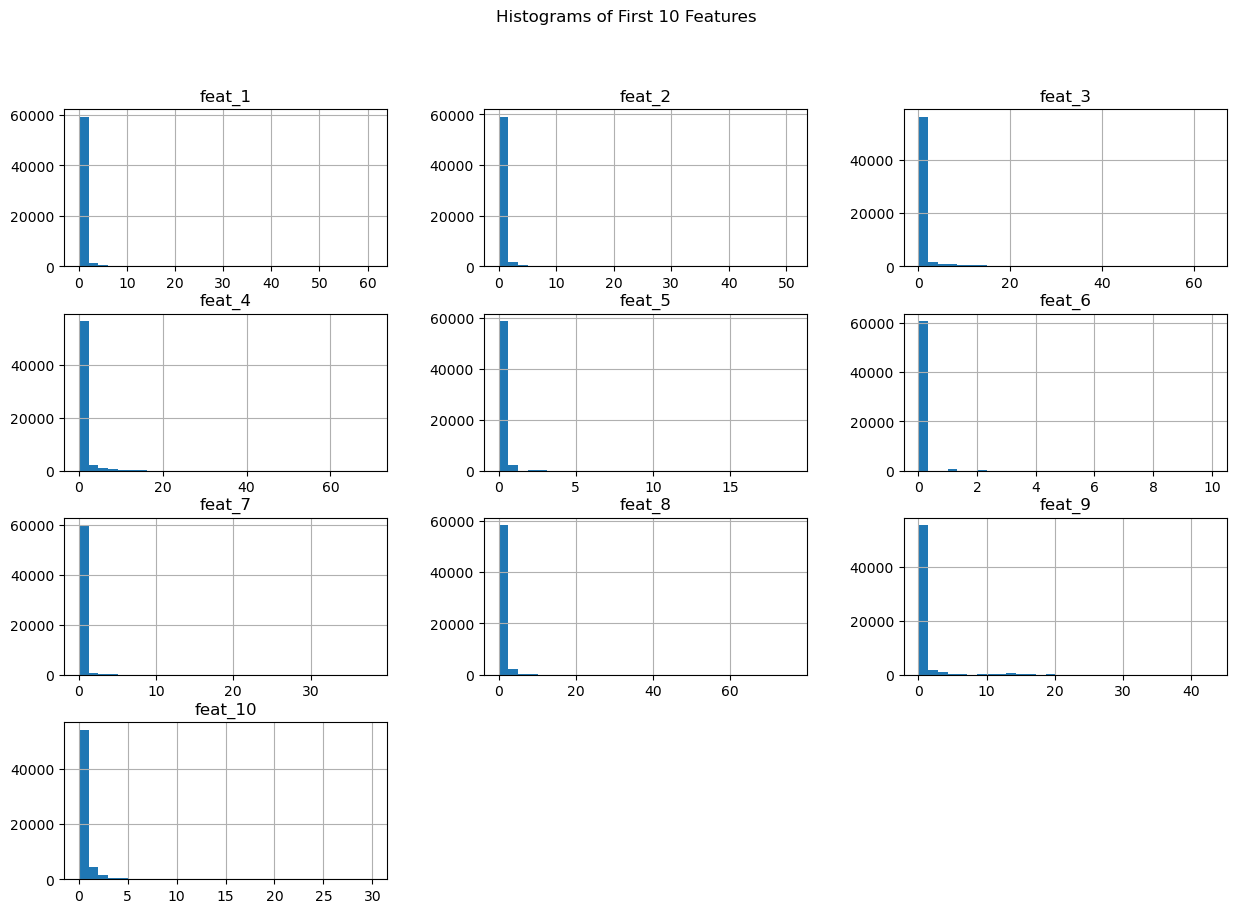

In [16]:
# Your code here

# Plotting histograms for selected features (first 10)
data.iloc[:, 1:11].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of First 10 Features")
plt.show()

Because there are so many zeroes, most values above zero will seem to be outliers. The safe decision for this data is to not delete any outliers and see what happens. With many 0s, sparse data is available and high values may be super informative. Moreover, without having any intuitive meaning for each of the features, we don't know if a value of ~260 is actually an outlier.

In [18]:
# Your code here

# Summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,61878.0,30939.500000,17862.784315,1.0,15470.25,30939.5,46408.75,61878.0
feat_1,61878.0,0.386680,1.525330,0.0,0.00,0.0,0.00,61.0
feat_2,61878.0,0.263066,1.252073,0.0,0.00,0.0,0.00,51.0
feat_3,61878.0,0.901467,2.934818,0.0,0.00,0.0,0.00,64.0
feat_4,61878.0,0.779081,2.788005,0.0,0.00,0.0,0.00,70.0
...,...,...,...,...,...,...,...,...
feat_89,61878.0,0.457772,1.527385,0.0,0.00,0.0,0.00,61.0
feat_90,61878.0,0.812421,4.597804,0.0,0.00,0.0,0.00,130.0
feat_91,61878.0,0.264941,2.045646,0.0,0.00,0.0,0.00,52.0
feat_92,61878.0,0.380119,0.982385,0.0,0.00,0.0,0.00,19.0


## Feature engineering and selection with PCA

Have a look at the correlation structure of your features using a [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

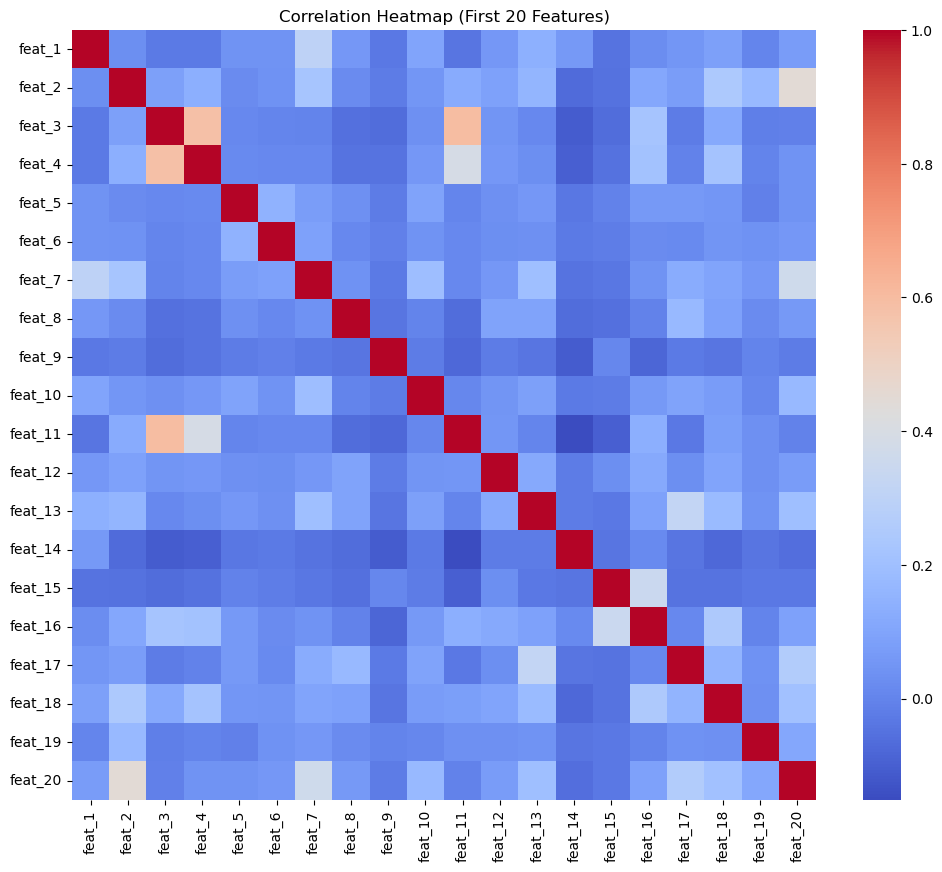

In [21]:
# Your code here

# Dropping id and target for correlation matrix
features_only = data.drop(['id', 'target'], axis=1)

# Computing correlation matrix
corr = features_only.corr()

# Plotting heatmap for first 20 features 
plt.figure(figsize=(12, 10))
sns.heatmap(corr.iloc[:20, :20], cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (First 20 Features)")
plt.show()

Use PCA to select a number of features in a way that you still keep 80% of your explained variance.

In [23]:
# Your code here

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_only)

In [24]:
# Your code here

# Applying PCA to determine number of components for 80% variance
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_scaled)

# Results
print(f"Original feature count: {features_only.shape[1]}")
print(f"Reduced feature count after PCA (80% variance): {X_pca.shape[1]}")

Original feature count: 93
Reduced feature count after PCA (80% variance): 49


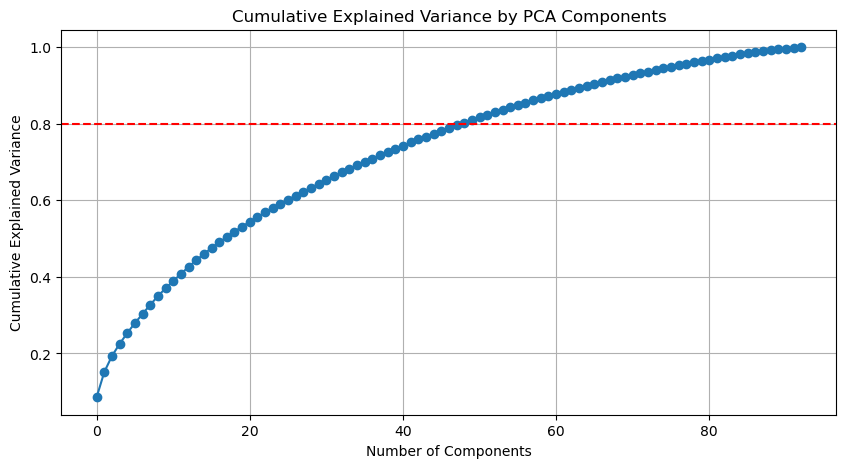

In [25]:
# Plotting cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(PCA().fit(X_scaled).explained_variance_ratio_), marker='o')
plt.axhline(y=0.80, color='r', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

## Create a train-test split with a test size of 40%

This is a relatively big training set, so you can assign 40% to the test set. Set the `random_state` to 42. 

In [27]:
# Your code here

from sklearn.model_selection import train_test_split

# Target labels
X = X_pca  
y = data['target']

In [28]:
# Your code here

# Encoding target labels if not numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.40, random_state=42, stratify=y_encoded
)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (37126, 49)
Test set size: (24752, 49)


## Create a baseline model

Create your baseline model *in a pipeline setting*. In the pipeline: 

- Your first step will be to scale your features down to the number of features that ensure you keep just 80% of your explained variance (which we saw before)
- Your second step will be to build a basic logistic regression model 

Make sure to fit the model using the training set and test the result by obtaining the accuracy using the test set. Set the `random_state` to 123. 

In [31]:
# Your code here

#Importing libraries
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [32]:
# Your code here

# Pipeline with Scaling, PCA, Logistic Regression
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('logreg', LogisticRegression(random_state=123, max_iter=1000))
])

# Fitting the pipeline
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.8)),
                ('logreg',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [33]:
# Your code here

# Predict and evaluate
y_pred = baseline_pipeline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)
print("Baseline Logistic Regression Accuracy:", baseline_accuracy)

Baseline Logistic Regression Accuracy: 0.7173561732385262


## Create a pipeline consisting of a linear SVM, a simple decision tree, and a simple random forest classifier

Repeat the above, but now create three different pipelines:
- One for a standard linear SVM
- One for a default decision tree
- One for a random forest classifier

In [36]:
# Your code here
# ⏰ This cell may take several minutes to run

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Linear SVM Pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('svm', SVC(kernel='linear', random_state=123))
])

# Decision Tree Pipeline
tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('tree', DecisionTreeClassifier(random_state=123))
])

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('rf', RandomForestClassifier(random_state=123))
])

# Fitting and scoring each
svm_pipeline.fit(X_train, y_train)
tree_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

print("Linear SVM Accuracy:", accuracy_score(y_test, svm_pipeline.predict(X_test)))
print("Decision Tree Accuracy:", accuracy_score(y_test, tree_pipeline.predict(X_test)))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pipeline.predict(X_test)))

Linear SVM Accuracy: 0.728385585003232
Decision Tree Accuracy: 0.627262443438914
Random Forest Accuracy: 0.7619586296056884


## Pipeline with grid search

Construct two pipelines with grid search:
- one for random forests - try to have around 40 different models
- one for the AdaBoost algorithm 

### Random Forest pipeline with grid search

In [40]:
# Your code here 

# imports
from sklearn.model_selection import GridSearchCV

In [41]:
# Your code here
# ⏰ This cell may take a long time to run!
rf_param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Pipeline with Grid Search
rf_grid_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('rf', RandomForestClassifier(random_state=123))
])

rf_grid_search = GridSearchCV(rf_grid_pipeline, rf_param_grid, cv=3, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

print("Best RF Parameters:", rf_grid_search.best_params_)
print("Best RF Accuracy:", rf_grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best RF Parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Best RF Accuracy: 0.752949466655349


Use your grid search object along with `.cv_results` to get the full result overview

In [43]:
# Your code here 

# Results
rf_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,97.103264,2.986497,0.751228,0.021119,None,1,2,150,"{'rf__max_depth': None, 'rf__min_samples_leaf'...",0.751050,0.752727,0.755071,0.752949,0.001649,1
1,66.007023,0.924922,0.594478,0.132107,None,1,2,100,"{'rf__max_depth': None, 'rf__min_samples_leaf'...",0.750727,0.751919,0.755475,0.752707,0.002017,2
5,89.257789,2.212857,0.679743,0.006005,None,1,5,150,"{'rf__max_depth': None, 'rf__min_samples_leaf'...",0.752182,0.750384,0.752808,0.751791,0.001027,3
26,97.020284,2.094440,0.853958,0.274026,20,1,2,150,"{'rf__max_depth': 20, 'rf__min_samples_leaf': ...",0.749919,0.752000,0.751919,0.751279,0.000962,4
11,103.202853,3.951422,0.840756,0.163517,None,2,5,150,"{'rf__max_depth': None, 'rf__min_samples_leaf'...",0.752828,0.748687,0.752323,0.751279,0.001845,5


### AdaBoost

In [45]:
# Your code here
# ⏰ This cell may take several minutes to run
from sklearn.ensemble import AdaBoostClassifier

ada_param_grid = {
    'ada__n_estimators': [50, 100, 150],
    'ada__learning_rate': [0.01, 0.1, 1]
}

ada_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('ada', AdaBoostClassifier(random_state=123))
])

ada_grid_search = GridSearchCV(ada_pipeline, ada_param_grid, cv=3, n_jobs=-1, verbose=1)
ada_grid_search.fit(X_train, y_train)

print("Best AdaBoost Parameters:", ada_grid_search.best_params_)
print("Best AdaBoost Accuracy:", ada_grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\user\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best AdaBoost Parameters: {'ada__learning_rate': 1, 'ada__n_estimators': 50}
Best AdaBoost Accuracy: 0.5960239738475033


Use your grid search object along with `.cv_results` to get the full result overview: 

In [47]:
# Your code here 

# Results
ada_results = pd.DataFrame(ada_grid_search.cv_results_)
ada_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ada__learning_rate,param_ada__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,30.642778,2.009605,0.545313,0.022373,1.0,50,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.609971,0.580929,0.597172,0.596024,0.011884,1
7,59.404882,3.598951,0.985422,0.142989,1.0,100,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.618293,0.586586,0.581980,0.595620,0.016143,2
8,67.619159,5.384833,1.028242,0.019684,1.0,150,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.622576,0.545697,0.601697,0.589990,0.032459,3
5,93.281284,4.176030,2.197822,0.732479,0.1,150,"{'ada__learning_rate': 0.1, 'ada__n_estimators...",0.586377,0.583111,0.588444,0.585977,0.002196,4
4,59.983698,5.239877,1.236333,0.203111,0.1,100,"{'ada__learning_rate': 0.1, 'ada__n_estimators...",0.552925,0.551111,0.561616,0.555217,0.004585,5


### Level-up (Optional): SVM pipeline with grid search 

As extra level-up work, construct a pipeline with grid search for support vector machines. 
* Make sure your grid isn't too big. You'll see it takes quite a while to fit SVMs with non-linear kernel functions!

In [49]:
# Your code here
# ⏰ This cell may take a very long time to run!
svm_param_grid = {
    'svm__C': [1, 10],
    'svm__gamma': ['scale', 0.1],
    'svm__kernel': ['rbf']
}

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('svm', SVC())
])

svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=3, n_jobs=-1, verbose=1)
svm_grid_search.fit(X_train, y_train)

print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Accuracy:", svm_grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best SVM Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best SVM Accuracy: 0.7687335431453078


Use your grid search object along with `.cv_results` to get the full result overview: 

In [51]:
# Your code here 

# Results
svm_results = pd.DataFrame(svm_grid_search.cv_results_)
svm_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,86.285041,7.746344,65.562260,14.344140,10,scale,rbf,"{'svm__C': 10, 'svm__gamma': 'scale', 'svm__ke...",0.767211,0.766869,0.772121,0.768734,0.002400,1
0,105.910568,6.822104,75.314635,6.833969,1,scale,rbf,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.754929,0.751354,0.756283,0.754188,0.002079,2
3,115.411707,4.565040,50.623913,0.748069,10,0.1,rbf,"{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel...",0.752505,0.751434,0.757495,0.753811,0.002641,3
1,157.406510,6.113037,82.290010,2.795436,1,0.1,rbf,"{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel'...",0.748546,0.746667,0.753051,0.749421,0.002679,4


## Note

Note that this solution is only one of many options. The results in the Random Forest and AdaBoost models show that there is a lot of improvement possible by tuning the hyperparameters further, so make sure to explore this yourself!

## Summary 

Great! You've gotten a lot of practice in using PCA in pipelines. What algorithm would you choose and why?